# Strategy Backtest
A Python project to backtest a simple trading strategy which is a trend-following strategy based on the crossover of two simple moving averages: a short term (50 day) average and a longe term (200 day) average. A position is intitiated when the short term crosses above the long term average (Golden Cross) and closed or reversed when it crosses below (Death Cross). 

In [48]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime


In [49]:
# Pull price data
ticker = 'AAPL'
start_date = datetime(2021, 1, 1)
end_date = datetime(2023, 12, 31)

df = yf.download(ticker, start=start_date, end=end_date)
df = df[['Close']].copy()
df

C:\Users\Leann\AppData\Local\Temp\ipykernel_41692\3665036054.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,AAPL
Date,
2021-01-04,126.096603
2021-01-05,127.655594
2021-01-06,123.358551
2021-01-07,127.567932
2021-01-08,128.669006
...,...
2023-12-22,191.974670
2023-12-26,191.429291


In [50]:
# Generate indicators
df = df[['Close']].copy()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()
df.tail()

Price,Close,SMA_50,SMA_200
Ticker,AAPL,,
Date,,,
2023-12-22,191.974670,183.750818,176.780252
2023-12-26,191.429291,184.037100,177.004107
2023-12-27,191.528442,184.327940,177.218729
2023-12-28,191.954849,184.658404,177.425015
2023-12-29,190.913666,184.993990,177.624120


In [51]:
# Generate buy/sell signals
df['Signal'] = 0
df['Signal'] = np.where(df['SMA_50'] > df['SMA_200'], 1, -1) # 1 = Buy signal , -1 = Sell signal
df['Position'] = df['Signal'].shift(1) #Use previous day's signal - avoids 'look ahead bias'
df.tail()

Price,Close,SMA_50,SMA_200,Signal,Position
Ticker,AAPL,,,,
Date,,,,,
2023-12-22,191.974670,183.750818,176.780252,1,1.0
2023-12-26,191.429291,184.037100,177.004107,1,1.0
2023-12-27,191.528442,184.327940,177.218729,1,1.0
2023-12-28,191.954849,184.658404,177.425015,1,1.0
2023-12-29,190.913666,184.993990,177.624120,1,1.0


In [52]:
# Simulate portfolio
initial_capital = 10000
df['Daily Return'] = df['Close'].pct_change()
df['Strategy Return'] = df['Daily Return'] * df['Position']
df['Portfolio Value'] = initial_capital * (1 + df['Strategy Return']).cumprod()
df['Buy & Hold'] = initial_capital * (1 + df['Daily Return']).cumprod()
df.tail()

Price,Close,SMA_50,SMA_200,Signal,Position,Daily Return,Strategy Return,Portfolio Value,Buy & Hold
Ticker,AAPL,,,,,,,,
Date,,,,,,,,,
2023-12-22,191.974670,183.750818,176.780252,1,1.0,-0.005548,-0.005548,7488.935456,15224.412494
2023-12-26,191.429291,184.037100,177.004107,1,1.0,-0.002841,-0.002841,7467.660186,15181.161555
2023-12-27,191.528442,184.327940,177.218729,1,1.0,0.000518,0.000518,7471.528093,15189.024702
2023-12-28,191.954849,184.658404,177.425015,1,1.0,0.002226,0.002226,7488.162232,15222.840590
2023-12-29,190.913666,184.993990,177.624120,1,1.0,-0.005424,-0.005424,7447.545646,15140.270288


In [56]:
# Metrics
total_return = df['Portfolio Value'].iloc[-1] / initial_capital - 1                                         # overall gain/loss from start to end
sharpe = (df['Strategy Return'].mean() / df['Strategy Return'].std()) * np.sqrt(252)                        # Risk-adjusted return
max_drawdownn = ((df['Portfolio Value'].cummax() - df['Portfolio Value']) / df['Portfolio Value'].cummax()).max()   # Largest drop from peak

print(f"Strategy Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe:.2%}")
print(f"Max Drawdown: {max_drawdownn:.2%}")


Strategy Return: -25.52%
Sharpe Ratio: -21.56%
Max Drawdown: 44.65%


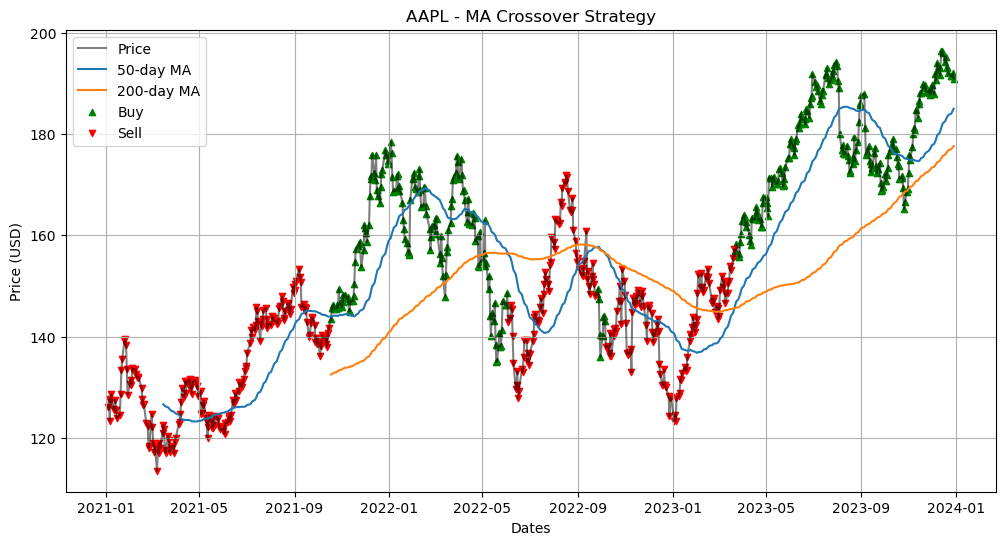

<Figure size 640x480 with 0 Axes>

In [72]:
# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label='Price', color = 'black', alpha=0.5)
plt.plot(df['SMA_50'], label='50-day MA')
plt.plot(df['SMA_200'], label='200-day MA')

buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

plt.scatter(buy_signals.index, buy_signals['Close'], marker='^', color='green', label='Buy', s=20)
plt.scatter(sell_signals.index, sell_signals['Close'], marker='v', color='red', label='Sell', s=20)

plt.title(f'{ticker} - MA Crossover Strategy')
plt.xlabel('Dates')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('ma_crossover_strategy.png')

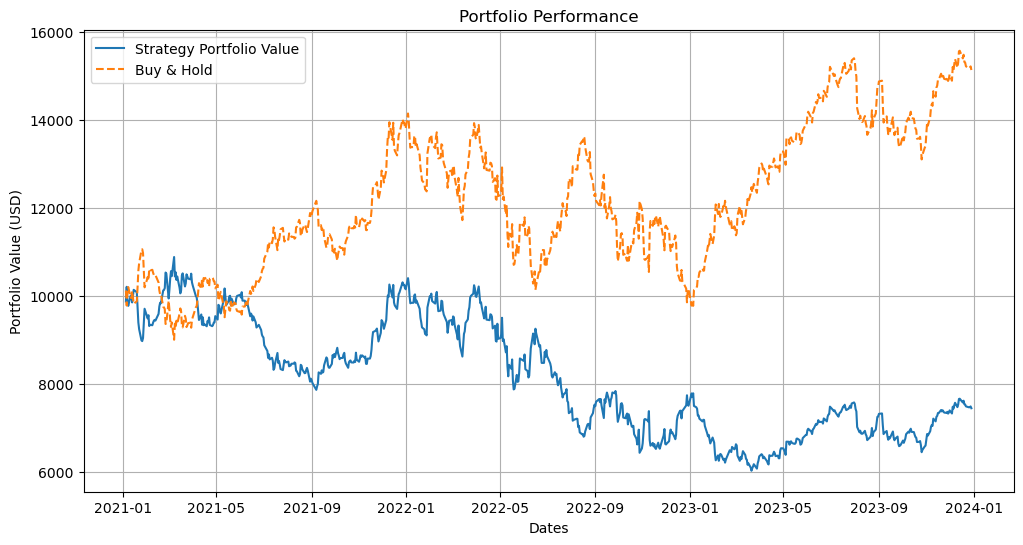

<Figure size 640x480 with 0 Axes>

In [74]:
# Plot portfolio performance
plt.figure(figsize=(12, 6))
plt.plot(df['Portfolio Value'], label='Strategy Portfolio Value')
plt.plot(df['Buy & Hold'], label='Buy & Hold', linestyle = '--' )
plt.title('Portfolio Performance')
plt.xlabel('Dates')
plt.ylabel('Portfolio Value (USD)')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig('portfolio_performance.png')